# Logistic Regression for Text Classification

In [2]:
# Import statements for data augmentation
!pip install transformers
!pip install nlpaug
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm
from sklearn.utils import shuffle
import nlpaug.augmenter.word.context_word_embs as aug
import torch
import random

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 5.2 MB/s eta 0:00:0000:010:01


In [3]:
# Import statements for post-processing
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
!pip install wordninja
import wordninja
from wordninja import split
!pip install unidecode
import unidecode
!pip install contractions
import contractions
from string import punctuation
!pip install ctranslate2
import ctranslate2
import transformers
from nltk.corpus import words
import string
!pip install -U simplemma
import simplemma

nltk.download('stopwords')
nltk.download('words')
stopwords_list = stopwords.words('english')

# Load the POS tagger for named entity recognition (NER) via NLTK
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 5.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541530 sha256=c4db17f654f2e48824f131b3c65745a6e4d6cf38ae4cd7953af33efe9f872109
  Stored in directory: /root/.cache/pip/wheels/aa/44/3a/f2a5c1859b8b541ded969b4cd12d0a58897f12408f4f51e084
Successfully built wordninja
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.3 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.2/37.2 MB 44.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 MB 24.8 MB/s eta 0:00:00:00:0100:01
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Dow

True

In [4]:
# Import statements for model building
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

## I. Post Processing for handling unbalanced dataset

## A. Reading the dataset

In [5]:
'''
  This model tests two different data augmentation scenarios.
  1) labeled_ovp_balanced used BERT to create augmented data
     by inserting contextually relevant words into the existing
     dataset under the minority class.
  2) labeled_ovp_balanced_substitute used BERT to augment existing
     data in the minority class by replacing the words with their
     synonyms and contextually appropriate words.
'''
ovp_df = pd.read_csv('/kaggle/input/lsa-ovp/labeled_ovp.csv')
ovp_df = ovp_df.drop(columns = ['Unnamed: 0'], errors = 'ignore')
ovp_df = ovp_df.drop(columns = ['Original'], errors = 'ignore')
ovp_df = ovp_df.dropna()
ovp_df

Content  Topic
0     bloc house vice president sarah answer extreme...      3
1     senator laugh senate probe sarah spend confide...      3
2     department education finance unit aware vice p...      3
3     senator laugh senate probe vice president sara...      3
4     wash hand sen laugh senate select committee co...      3
...                                                 ...    ...
2458                                        budget brat      2
2459  remember budget hearing leni congress clean bu...      2
2460                               oblige budget budget      2
2461  parang alas approval budget fall fall reductio...      2
2462                             time bias budget enemy      2

[2463 rows x 2 columns]

In [6]:
# X is a pandas series that contains the text
X = ovp_df['Content']
# y is a pandas series that contains the respective labels
y = ovp_df['Topic']

In [7]:
# Split off 10% of the data for unseen validation
X_temp, X_unseen, y_temp, y_unseen = train_test_split(X, y,
                                              test_size = 0.10,
                                              random_state = 42,
                                              stratify = y)

# Split the remaining 90% into (80/20) for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_temp,
                                                    y_temp,
                                                    test_size = 0.20,
                                                    random_state = 42,
                                                    stratify = y_temp)

print(f"Training data size: {X_train.shape[0]}")
print(f"Testing data size: {X_test.shape[0]}")
print(f"Unseen validation data size: {X_unseen.shape[0]}")

Training data size: 1772
Testing data size: 444
Unseen validation data size: 247


## B. Data Augmentation on train split

In [8]:
# Defining a BERT uncased model as an augmenter for sampling the minority class
device = 'cuda' if torch.cuda.is_available() else 'cpu'
augmenter_sub = aug.ContextualWordEmbsAug(model_path = 'bert-base-uncased',
                                          action = 'substitute',
                                          device = device)
augmenter_ins = aug.ContextualWordEmbsAug(model_path = 'bert-base-uncased',
                                          action = 'insert',
                                          device = device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [9]:
sample_text = X.iloc[50]
sample_text

'percent target build department education vice president sarah accord commission audit read'

In [10]:
# Sample test of substitute augment
augmented1 = augmenter_sub.augment(sample_text)
print("Sample augmentation via substitution: ")
augmented1

Sample augmentation via substitution: 


['2012 target build for education vice president sarah accord first audit by']

In [11]:
tfidf_vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_unseen_tfidf = tfidf_vectorizer.transform(X_unseen)

In [12]:
# Sample test of insertion augment
augmented2 = augmenter_ins.augment(sample_text)
print("Sample augmentation via insertion: ")
augmented2

Sample augmentation via insertion: 


['percent progressive target build department education vice president sarah cole accord commission public audit agenda read']

In [13]:
# Data Augmentation
'''

  Input:
    df: Input DataFrame
    label: The minorit class to be filled with augmented data
    augmenter: The text augmentation model
    samples: The number of samples from the minority class
             that the augmenter would augment.
    repetitions: How many times the augmenter would
                 augment each selected sample.
  Output:
    augmented_df: A dataframe that samples the minority class and matches that
                  of the majority class.
'''
def augment_resample(df, label, aug_sub, aug_ins,
                     maj_size, repetitions = 1):
    augments = []
    minority_data = df[df['Topic'] == label].reset_index(drop=True)
    min_size = len(minority_data)
    samples = maj_size - min_size

    for i in tqdm(np.random.randint(0, len(minority_data), samples)):
        # Augmentation loop
        for _ in range(repetitions):
            # 50/50 chance to substitute or insert as augment
            augmenter = random.choice([aug_sub, aug_ins])
            augment_data = augmenter.augment(minority_data['Content'].iloc[i])
            if isinstance(augment_data, list):
                augment_data = augment_data[0]
            augments.append(augment_data)
            if len(augments) >= samples:
                break

    # Create new dataframe with augmented data
    data = {
        'Content': augments,
        'Topic': label
    }
    augment_df = pd.DataFrame(data)
    augmented_df = pd.concat([df, augment_df], ignore_index=True)
    augmented_df = shuffle(augmented_df).reset_index(drop=True)
    
    return augmented_df

In [14]:
maj_size = y_train.value_counts().max()

'''
    Augment the minority classes to match 
    the majority class size for the train set.
''' 
X_train_augment_df = augment_resample(pd.DataFrame({'Content': X_train, 'Topic': y_train}),
                                   label = 1,
                                   aug_sub = augmenter_sub,
                                   aug_ins = augmenter_ins,
                                   maj_size = maj_size,
                                   repetitions = 1)

X_train_augment_df = augment_resample(X_train_augment_df,
                                   label = 2,
                                   aug_sub = augmenter_sub,
                                   aug_ins = augmenter_ins,
                                   maj_size = maj_size,
                                   repetitions = 1)

X_train_augment_df = augment_resample(X_train_augment_df,
                                   label = 4,
                                   aug_sub = augmenter_sub,
                                   aug_ins = augmenter_ins,
                                   maj_size = maj_size,
                                   repetitions = 1)

X_train_augment_df = augment_resample(X_train_augment_df,
                                   label = 5,
                                   aug_sub = augmenter_sub,
                                   aug_ins = augmenter_ins,
                                   maj_size = maj_size,
                                   repetitions = 1)

100%|██████████| 987/987 [00:46<00:00, 21.01it/s]


In [15]:
X_train_augmented_tfidf = tfidf_vectorizer.transform(X_train_augment_df['Content']) 
y_train_augmented = X_train_augment_df['Topic']

### In order to avoid data leakage, the train split would be solely augmented.

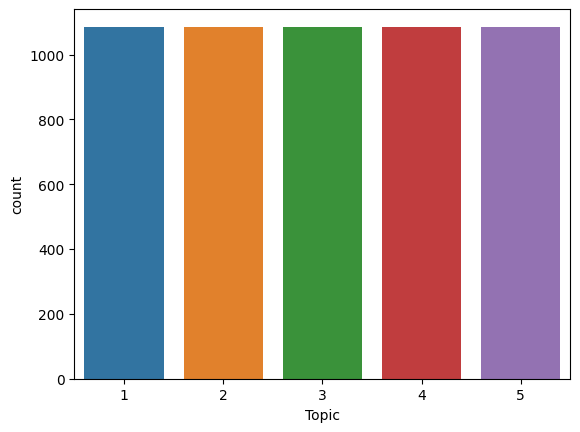

Topic
2    1086
5    1086
4    1086
3    1086
1    1086
Name: count, dtype: int64


In [16]:
sns.countplot(x = 'Topic', data = X_train_augment_df)
plt.show()
print(f"{X_train_augment_df['Topic'].value_counts()}")

In [17]:
# Helper methods for post-processing and cleaning after augmentation

# Load English words for detection
english_vocab = set(words.words())

'''
  A basic component of the method detect_non_english where it identifies
  if a given word in the document is English or not through comparing current
  word with all known words with nltk's english dictionary
  (saved as english_vocab).
'''
def is_english(word):
    return word.lower() in english_vocab

'''
  Uses NLTK's POS tagger to identify proper nouns
'''
def detect_proper_nouns(corpus):
  # Tokenize and POS tag the corpus
  words = word_tokenize(corpus)
  pos_tags = nltk.pos_tag(words)

  # Filter out proper nouns (NNP or NNPS)
  proper_nouns = {word for word, pos in pos_tags if pos == 'NNP' or pos == 'NNPS'}

  return proper_nouns

print("Successfully initialized helper methods for translation and preprocessing!")

def preprocess_text(post_text):

    # Detect proper nouns with NLTK POS tagging
    proper_nouns = detect_proper_nouns(post_text)

    # Helper function to pre-process english words besides proper nouns
    def process_word(word):
        if word in proper_nouns:
          return word

        # Removal of html tags and similar existing symbols
        word = re.sub(r'<.*?>', '', word)

        # Removal of urls via the following format
        word = re.sub(r'https?://\S+|www\.\S+|.com', '', word)

        # Removes the numbers
        word = re.sub(r'\d+', '', word)

        # Removing single characters
        word = re.sub(r'\s+[a-zA-Z]\s+', '', word)

        # remove punctutation marks and replace them with empty strings
        word = word.translate(str.maketrans('', '', punctuation))

        # Check if the word is in English vocabulary
        if word.lower() not in english_vocab:
            return ''

        return word

    # Apply the helper function to each word in the text
    post_text = [process_word(word) for word in post_text.split()]

    # Remove words with length < 2 and stopwords from the processed words
    post_text = [word for word in post_text if len(word) > 2]

    # Join the words back into a single string
    post_text = ' '.join(post_text)

    # Turns seemingly combined and unspaced words to proper format
    post_text = re.sub(r'\s+', ' ', post_text).strip()

    # Converts the texts to lowercase format
    post_text = post_text.lower()

    return post_text

print("Finished initializing preprocess_text method!")


def lemmatize(text):
    out_comment = ''
    for word in text.split():
        out_comment += simplemma.lemmatize(word, lang = 'en') + ' '
    return out_comment.strip()

print("Lemmatize method successfully initialized!")


'''
  Assumes that you have stopwords-en.txt & tagalog_stop_words.txt
   which are explicitly downloaded (will be provided).

  The code loads the stop words from the files, stores them in an array of stop
  words and updates it with every words added to avoid duplicates. At the end,
  'all_stopwords' would contain all of the collated stopwords
'''

def get_stopwords(filename):

  stopwords = set()
  if isinstance(filename, list):
    # Allows us to add a previous existing list of stop words (because we have)
    stopwords.update(filename)
  else:
    # For the files containing stopwords
    with open(filename, 'r') as f:
      for line in f:
        words = line.rstrip('\n').split(',') if ',' in line else line.strip().split()
        stopwords.update(words)
  return list(stopwords)

stopwords = get_stopwords("/kaggle/input/lsa-ovp/stopwords-en.txt")
fil_stop_words = get_stopwords("/kaggle/input/lsa-ovp/tagalog_stop_words.txt")
custom = ["duct", "yan", "mag", "kayo", "ako", "aba", "nag", "tao", "yang", "san"]
all_stopwords = list(set(stopwords_list + stopwords + fil_stop_words + custom))
print(all_stopwords)

"""
    Remove stopwords from a specified column in the DataFrame.
    Takes in the DataFrame containing the text data.
    A list of stopwords to be removed. And the name of the column containing text data.
"""
def remove_stopwords(df, stopwords, text_column = 'Content'):
    def process_text(text):
        return ' '.join(word for word in text.split() if word.lower() not in stopwords)

    # Apply the process_text function to the specified column
    df.loc[:, text_column] = df[text_column].apply(process_text)

    return df
print("Successfully initialized remove_stopwords!")

Successfully initialized helper methods for translation and preprocessing!
Finished initializing preprocess_text method!
Lemmatize method successfully initialized!
['clear', 'seems', 'til', 'cy', 'never', 'thatve', 'older', 'thereby', 'ended', 'promptly', "didn't", "i'd", 'tayo', 'gp', 'ask', 'hasn', 'gq', 'yours', 'below', 'hn', 'away', 'za', 'when', 'accordingly', 'ts', 'wherein', 'his', 'soon', 'ilan', 'low', 'small', 'mq', "how'll", 'furthered', 'oh', 'get', 'become', 'bilang', 'kailangan', "where'd", 'hence', 'thanks', 'copy', 'having', "'twas", 'formerly', 'bd', 'gumawa', 'throug', 'htm', 'pagkakaroon', 'see', 'sv', 'es', 'hindi', 'given', 'wherever', 'happens', 'slightly', 'la', 'considering', "ain't", 'kanyang', 'round', 'of', 'fify', 'kung', 'theyve', 'needn', 'the', 'meanwhile', 'mahusay', 'ee', 'un', 'ordered', 'pagitan', 'mv', 'maaari', 'edu', 'whom', "how's", 'whose', 'areas', 'regards', 'bababa', 'homepage', 'seem', 'kanila', 'that', "when'll", 'bj', 'since', 'take', 'wha

In [18]:
# Combine all functions into one preprocessing method
def preprocess_pipeline(in_corpus, stopwords, save_remove_chars = True,
                        save_lemmatize = True,save_filter_stopwords = True):
  corpus = in_corpus.copy()
  if save_remove_chars:
    print("Cleaning documents...")
    corpus.loc[:, 'Content'] = corpus['Content'].apply(preprocess_text)
  if save_lemmatize:
    print("Lemmatizing words...")
    corpus.loc[:, 'Content'] = corpus['Content'].apply(lemmatize)
  if save_filter_stopwords:
    print("Filtering stopwords...")
    corpus = remove_stopwords(corpus, stopwords)
  return corpus

In [19]:
# Training the model on training data
lr_model = LogisticRegression(multi_class = 'ovr',
                              solver = 'lbfgs',
                              max_iter = 100,
                              random_state = 0)
lr_model.fit(X_train_augmented_tfidf, y_train_augmented)

LogisticRegression(multi_class='ovr', random_state=0)

In [20]:
# Evaluate logistic regression performance on the test set
print("Performance Metrics of Logistic Regression: ")
y_pred = lr_model.predict(X_test_tfidf)

print("\nPerformance on test data:")
print(f"Accuracy on test data: {(accuracy_score(y_test, y_pred) * 100):.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Evaluate logistic regression performance on unseen split
y_unseen_pred = lr_model.predict(X_unseen_tfidf)
print("\nPerformance on unseen validation data:")
print(f"Accuracy on unseen data: " +
      f"{(accuracy_score(y_unseen, y_unseen_pred) * 100):.2f}%")
print(classification_report(y_unseen, y_unseen_pred))

Performance Metrics of Logistic Regression: 

Performance on test data:
Accuracy on test data: 84.46%

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.77      0.87        22
           2       0.76      0.96      0.85       113
           3       0.96      0.82      0.88       272
           4       0.60      0.75      0.67        12
           5       0.47      0.68      0.56        25

    accuracy                           0.84       444
   macro avg       0.76      0.80      0.77       444
weighted avg       0.87      0.84      0.85       444


Performance on unseen validation data:
Accuracy on unseen data: 83.40%
              precision    recall  f1-score   support

           1       1.00      0.83      0.91        12
           2       0.76      1.00      0.86        63
           3       0.98      0.76      0.86       152
           4       0.55      1.00      0.71         6
           5       0.44      0.79      0.

# Using GridSearchCV to iteratively improve Logistic Regression

In [21]:
grid_lr_model = LogisticRegression(random_state = 0)

In [22]:
hyperparameters = {"multi_class": ["ovr", "multinomial"],
                   "class_weight" : [None, "balanced"],
                   "solver" : ["lbfgs", "newton-cg", "sag", "saga"],
                   "max_iter": [1000, 1500, 2000]
                   }

In [24]:
# Set up GridSearchCV
grid_search = GridSearchCV(estimator = grid_lr_model,
                           param_grid = hyperparameters,
                           cv = 5,
                           verbose = 2,
                           n_jobs = -1,
                           scoring = {
                            'accuracy': 'accuracy',
                            'f1_score': 'f1_macro'
                           },
                           refit = 'accuracy'
                          )
    
# Fit the model to the training data
grid_search.fit(X_train_augmented_tfidf, y_train_augmented)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_iter': [1000, 1500, 2000],
                         'multi_class': ['ovr', 'multinomial'],
                         'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']},
             refit='accuracy',
             scoring={'accuracy': 'accuracy', 'f1_score': 'f1_macro'},
             verbose=2)

In [25]:
# Print the best parameters and the corresponding score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

# Evaluate the model on the test data
y_pred = grid_search.best_estimator_.predict(X_test_tfidf)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Best Parameters: {'class_weight': None, 'max_iter': 1000, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
Best Cross-Validation Score: 0.948987108655617
Test Accuracy: 0.8783783783783784


In [26]:
best_lr_model = LogisticRegression(class_weight = None,
                                   max_iter = 1000,
                                   multi_class = 'multinomial',
                                   solver = 'lbfgs')
best_lr_model.fit(X_train_augmented_tfidf, y_train_augmented)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [27]:
# Evaluate logistic regression performance on the test set
print("Performance Metrics of Logistic Regression: ")
y_pred = best_lr_model.predict(X_test_tfidf)

print("\nPerformance on test data:")
print(f"Accuracy on test data: {(accuracy_score(y_test, y_pred) * 100):.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Evaluate logistic regression performance on unseen split
y_unseen_pred = best_lr_model.predict(X_unseen_tfidf)
print("\nPerformance on unseen validation data:")
print(f"Accuracy on unseen data: " +
      f"{(accuracy_score(y_unseen, y_unseen_pred) * 100):.2f}%")
print(classification_report(y_unseen, y_unseen_pred))

Performance Metrics of Logistic Regression: 

Performance on test data:
Accuracy on test data: 87.84%

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.77      0.87        22
           2       0.82      0.96      0.89       113
           3       0.96      0.88      0.92       272
           4       0.64      0.75      0.69        12
           5       0.53      0.68      0.60        25

    accuracy                           0.88       444
   macro avg       0.79      0.81      0.79       444
weighted avg       0.89      0.88      0.88       444


Performance on unseen validation data:
Accuracy on unseen data: 86.64%
              precision    recall  f1-score   support

           1       1.00      0.83      0.91        12
           2       0.77      1.00      0.87        63
           3       0.98      0.82      0.90       152
           4       0.67      1.00      0.80         6
           5       0.53      0.71      0.